# Should cash transfer programs be targeted by household income level to increase student enrollment rates?

## Packages

In [3]:
!pip install "networkx<=2.6" -q
!pip install ISLP -q
!pip install l0bnb -q
!pip install "dowhy<=0.8" -q
!pip install causaldag
!pip install "mapclassify<2.10" -q
!pip install causalinference -q
!pip install causalgraphicalmodels -q
!pip install lightgbm -q
!pip install econml -q
!pip install causalml -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mapclassify 2.9.0 requires networkx>=3.2, but you have networkx 2.5.1 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.5.1 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.formula.api as smf
from statsmodels.api import OLS
import sklearn.model_selection as skm
import statsmodels.api as sm

import sklearn.linear_model as skl
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression 
from sklearn.pipeline import Pipeline 
from sklearn.tree import (DecisionTreeClassifier as DTC,DecisionTreeRegressor as DTR,plot_tree,export_text)
from sklearn.metrics import (accuracy_score,log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)

from ISLP import load_data
from ISLP.models import ModelSpec as MS,Stepwise,sklearn_selected,sklearn_selection_path
from functools import partial

import networkx as nx
from dowhy import CausalModel
     
from l0bnb import fit_path 

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from xgboost import XGBRegressor
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

from ISLP.bart import BART
from scipy import stats
plt.style.use('fivethirtyeight')
import graphviz
COLORS = [
    '#00B0F0',
    '#FF0000'
]

import lightgbm
from lightgbm import LGBMRegressor, LGBMClassifier
from joblib import Parallel, delayed
from toolz import curry

import warnings
warnings.filterwarnings("ignore")

Failed to import duecredit due to No module named 'duecredit'


## Data

In [6]:
data = pd.read_stata("data.dta")

In [7]:
data_r1 = data[data['round'] == 1.0]
data_r2 = data[data['round']==2.0]
data_r3 = data[data['round']==3.0]

data_r1 = data_r1[['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize', 'female_headed', 
           'highest_grade_baseline', 'father_alive', 'mother_alive', 'age_R1', 'mobile', 
                   'eaid', 'ea_status', 'never_had_sex_baseline', 'cond_treat_year2']].reset_index(drop=True) #group
data_r2 = data_r2[['uncond_treat_year2', 'treatment_year2','asset_index_baseline', 'highest_grade_baseline', 
                   'never_had_sex_baseline']]
data_r3 = data_r3[['asset_index_baseline', 'highest_grade_baseline', 'never_had_sex_baseline',
                   'math_malawi_std', 'eng_std', 'cog_std', 'inschool_term1_2010', 'eaid',
                  'num_terms_enrolled', 'cond_treat_year3', 'uncond_treat_year3', 'treatment_year3',
                   'ever_pregnant', 'ever_married']].reset_index(drop=True)

#joining data
data_r3 = data_r3.rename(columns={'ever_pregnant': 'ever_pregnant_r3', 'ever_married':'ever_married_r3'})
alldata = pd.merge(data_r1, data_r3, on=['eaid','asset_index_baseline', 'highest_grade_baseline', 
                                         'never_had_sex_baseline'], how="inner") #merge for the same people
alldata = pd.merge(alldata, data_r2, on=['asset_index_baseline', 'highest_grade_baseline', 
                                         'never_had_sex_baseline'], how="inner")

In [8]:
# latex_table = (alldata[alldata['treatment_year3']==0.0][['math_malawi_std', 'eng_std', 'cog_std']].describe().transpose()).to_latex()
# print(latex_table)

In [9]:
# latex_table = (alldata[alldata['treatment_year3']==0.0][['asset_index_baseline', 'ever_pregnant', 'highest_grade_baseline','age_R1','never_had_sex_baseline']].describe().transpose()).to_latex()
# print(latex_table)

String values set to 0

In [10]:
def to_01(s: pd.Series, mapping: dict) -> pd.Series:
    # Normalize strings, map to {0,1}, then fall back to numeric, fill NA, cast to int
    s_norm = s.astype(str).str.strip().str.lower()
    mapped = s_norm.map(mapping)
    mapped = mapped.where(~mapped.isna(), pd.to_numeric(s, errors='coerce'))
    return mapped.fillna(0).astype('int8')

for col in ['never_had_sex', 'father_alive', 'mother_alive', 'mobile', 'inschool_term1_2010', 'ever_married_r3']:
    alldata[col] = to_01(alldata[col], {
        'yes':1, 'no':0, 'true':1, 'false':0, 'y':1, 'n':0, '1':1, '0':0
    })
    
for col in ['ea_status']:
    alldata[col] = to_01(alldata[col], {
        'treatment':1, 'treated':1, 'treat':1,
        'control':0, 'ctrl':0, '0':0, '1':1
    })
    
alldata = alldata.dropna()

In [11]:
alldata = alldata[['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize', #dummy - remember to exclude
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1', 'mobile', 'ea_status',
       'never_had_sex_baseline', 'math_malawi_std', 'eng_std', 'cog_std',
       'inschool_term1_2010', 'num_terms_enrolled', 'cond_treat_year3',
       'uncond_treat_year3', 'treatment_year3', 'treatment_year2',
       'ever_pregnant_r3', 'ever_married_r3', 'uncond_treat_year2']]

Scaling continuous variables

In [12]:
scale_data = alldata[['asset_index_baseline']]
scaler = MinMaxScaler(feature_range=(0,1))
X1 = scaler.fit_transform(scale_data)
alldata['asset_index_baseline'] = scaler.fit_transform(scale_data)

Yi = α+ β1⋅CCTi + β2⋅UCTi + γ⋅Ai + δ1⋅(CCTi×Ai) + δ2⋅(UCTi×Ai) + Xi⋅θ+ εi

In [13]:
alldata = alldata[
    (alldata['cond_treat_year3'] == 1) |
    ((alldata['treatment_year3'] == 0) & (alldata['treatment_year2'] == 0))
    
]

Data for OLS:

In [14]:
ols_data = alldata.copy()

Data for other models (interaction terms):

In [15]:
alldata['treatment_year3*uncond_treat_year3'] = alldata['treatment_year3'] * alldata['uncond_treat_year3']
alldata['treatment_year3*cond_treat_year3'] = alldata['treatment_year3'] * alldata['cond_treat_year3']
alldata['heterogeneous_asset_treatment'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['uncond_treat_year3']
alldata['treatment_year3*uncond_treat_year3*asset_index_baseline'] = alldata['asset_index_baseline'] * alldata['treatment_year3']*alldata['uncond_treat_year3']
alldata['treatment_year2+treatment_year3'] = alldata['treatment_year3'] + alldata['treatment_year2']

Creating binary treatment variable

In [16]:
alldata['treated'] = np.where(
    (alldata['treatment_year3*cond_treat_year3'] == 1),
    1,
    np.where(
        (alldata['treatment_year2+treatment_year3'] == 0) ,
        0,
        np.nan
    )
)

In [17]:
alldata = alldata[['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1','never_had_sex_baseline', 'math_malawi_std', 'eng_std', 'cog_std',
                  'num_terms_enrolled','ever_pregnant_r3', 'ever_married_r3',
                  'heterogeneous_asset_treatment','treated']]

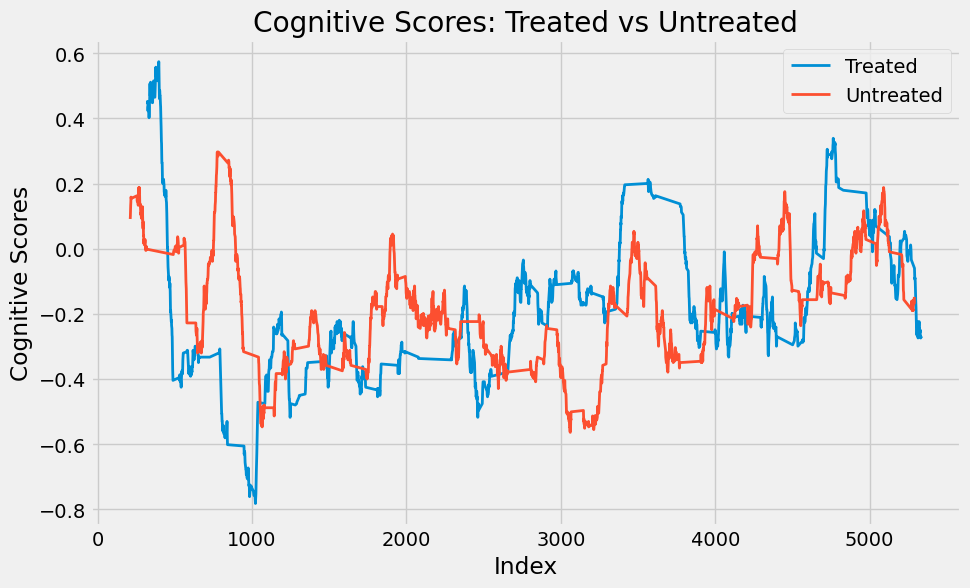

In [18]:
window = 100  # adjust if you want smoother/less smooth

treated = alldata[alldata['treated'] == 1]['cog_std'].rolling(window).mean()
untreated = alldata[alldata['treated'] == 0]['cog_std'].rolling(window).mean()

plt.figure(figsize=(10,6))

plt.plot(treated.index, treated, label='Treated', linewidth=2)
plt.plot(untreated.index, untreated, label='Untreated', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Cognitive Scores')
plt.title('Cognitive Scores: Treated vs Untreated')
plt.legend()
plt.grid(True)

plt.show()

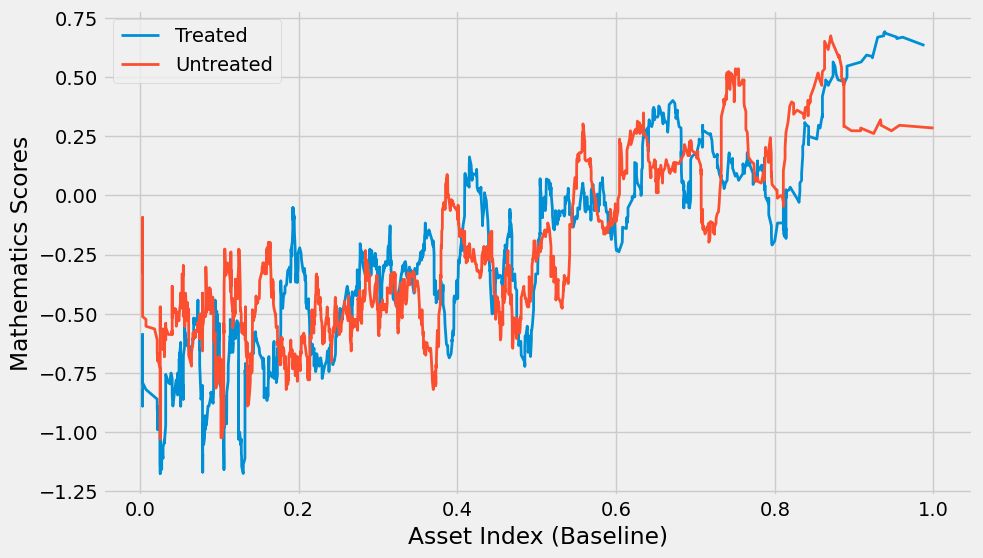

In [19]:
alldata_sorted = alldata.sort_values('asset_index_baseline')

# Smooth with rolling mean (adjust window if needed)
window = 50

treated = (
    alldata_sorted[alldata_sorted['treated'] == 1]
    .set_index('asset_index_baseline')['math_malawi_std']
    .rolling(window)
    .mean()
)

untreated = (
    alldata_sorted[alldata_sorted['treated'] == 0]
    .set_index('asset_index_baseline')['math_malawi_std']
    .rolling(window)
    .mean()
)

plt.figure(figsize=(10,6))

plt.plot(treated.index, treated, label='Treated', linewidth=2)
plt.plot(untreated.index, untreated, label='Untreated', linewidth=2)

plt.xlabel('Asset Index (Baseline)')
plt.ylabel('Mathematics Scores')
plt.title("")
plt.legend()
plt.grid(True)

plt.show()

In [13]:
alldata['asset_dummy'] = (alldata['asset_index_baseline'] >= alldata['asset_index_baseline'].mean()).astype(int)
alldata['treated'] = alldata['treated'] * alldata['asset_dummy']

In [14]:
#testing w asset dummy
alldata = alldata[[ 'ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1', 'never_had_sex_baseline', 'math_malawi_std',
       'eng_std', 'cog_std', 'num_terms_enrolled', 'ever_pregnant_r3',
       'ever_married_r3', 'heterogeneous_asset_treatment', 'treated']]

## 1. OLS

In [16]:
res = smf.ols(
    formula="""math_malawi_std ~ age_R1 + female_headed + ever_pregnant + never_had_sex
               + father_alive + mother_alive + highest_grade_baseline
               + treatment_year3:cond_treat_year3 + treatment_year3:uncond_treat_year3
               + treatment_year3:cond_treat_year3*asset_index_baseline
               + treatment_year3:uncond_treat_year3*asset_index_baseline
               """,
    data=ols_data
).fit()
# print(res.summary().as_latex())
# res.summary()

## 2. Ridge

In [15]:
design = MS(alldata.columns.drop(['math_malawi_std','eng_std','cog_std', 'asset_index_baseline'])).fit(alldata)
Y = np.array(alldata['math_malawi_std'])
X = design.transform(alldata)

D = design.fit_transform(alldata)
D = D.drop('intercept', axis=1)
D = D.dropna()
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs/ X_scale[None,:]
Xs = np.nan_to_num(Xs, nan=0.0)
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

Alpha: 0.009270473879393334
MSE: 0.6738070750544034
Test Score: [0.68704597]


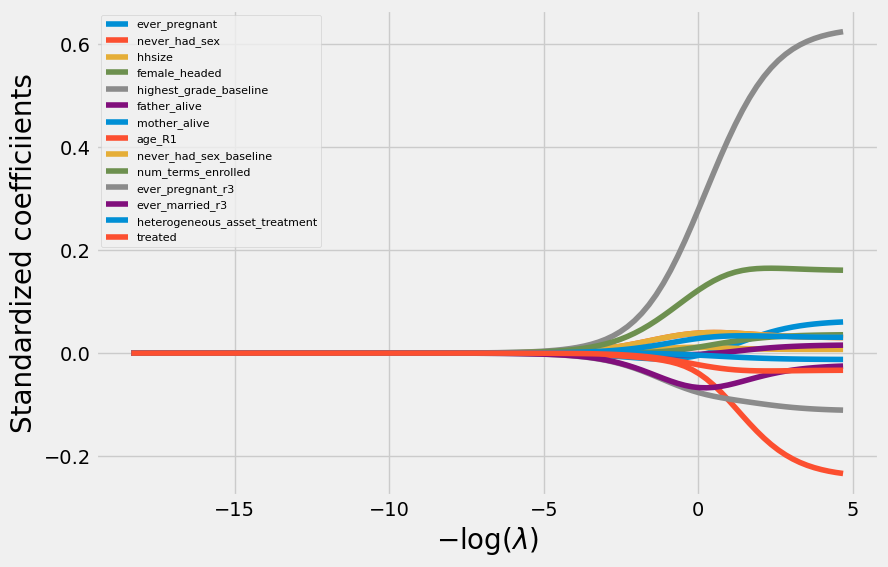

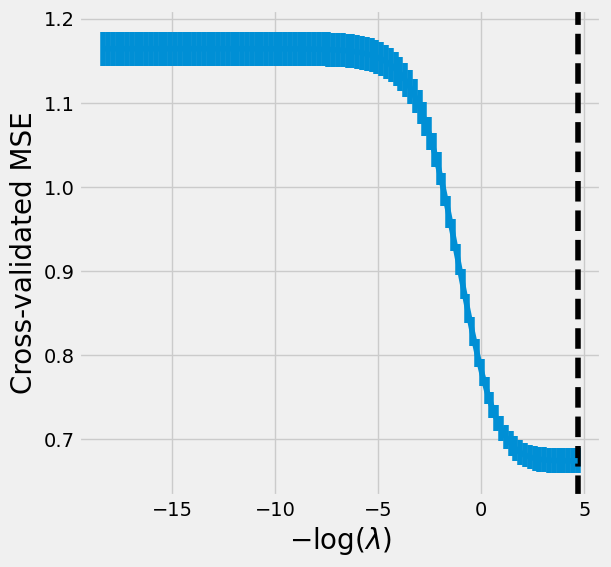

In [16]:
scaler = StandardScaler(with_mean=True,  with_std=True)
param_grid = {'ridge__alpha': lambdas}
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)

ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);
pipeCV.fit(X, Y)
tuned_ridge = pipeCV.named_steps['ridge']
print("Alpha:", tuned_ridge.alpha_)

y_hat = pipeCV.predict(X)
mse_train = mean_squared_error(Y, y_hat)

mean_mse_per_alpha = tuned_ridge.mse_path_.mean(axis=1)
mse_cv = mean_mse_per_alpha.min()  

print("MSE:", mse_cv)
# print("Coef:",tuned_ridge.coef_)

lambdas, soln_array = skl.ElasticNet.path(Xs,
                                    Y,
                                    l1_ratio=0.,
                                    alphas=lambdas)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(9,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

ridgeCV_fig, ax = subplots(figsize=(6,6))
ax.errorbar(-np.log(tuned_ridge.alphas_),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

#Evaluate Error:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=0)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
print("Test Score:",-results['test_score'])

## 3. Lasso

Alpha: 0.003001592116742823
Test Score: [0.68659657]


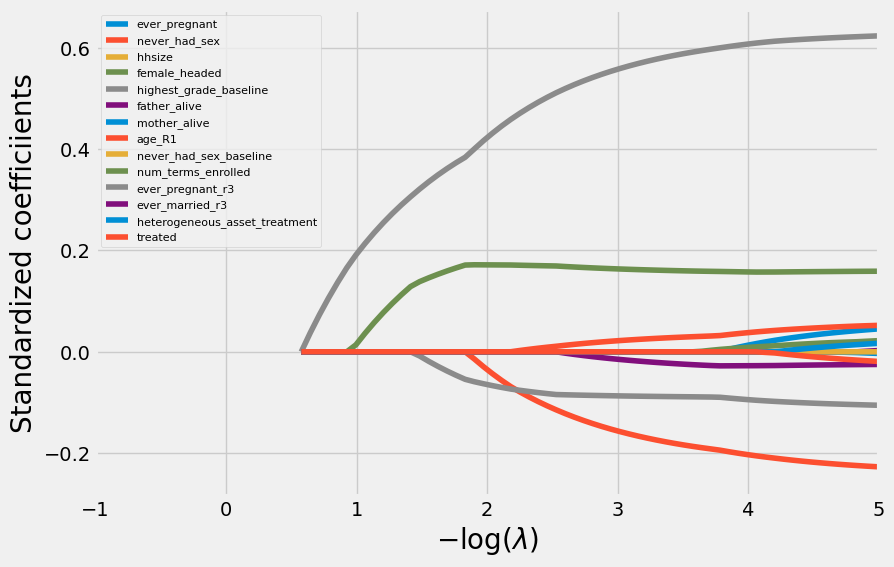

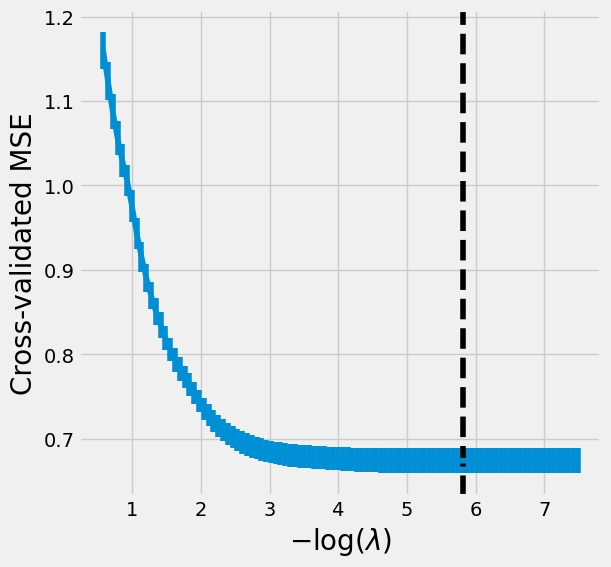

In [18]:
lassoCV = skl.ElasticNetCV(n_alphas=100, #what is n_alphas vs. 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
print("Alpha:",tuned_lasso.alpha_)

lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(9,6))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_xlim(-1, 5)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

lassoCV_fig, ax = subplots(figsize=(6,6))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# ax.set_ylim([0.50,0.58])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=0)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=1,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)]);
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
print("Test Score:",-results['test_score'])

## 4. Regression Tree

Accuracy Score: 0.6247403646434341
MSE: 0.9915376290422553


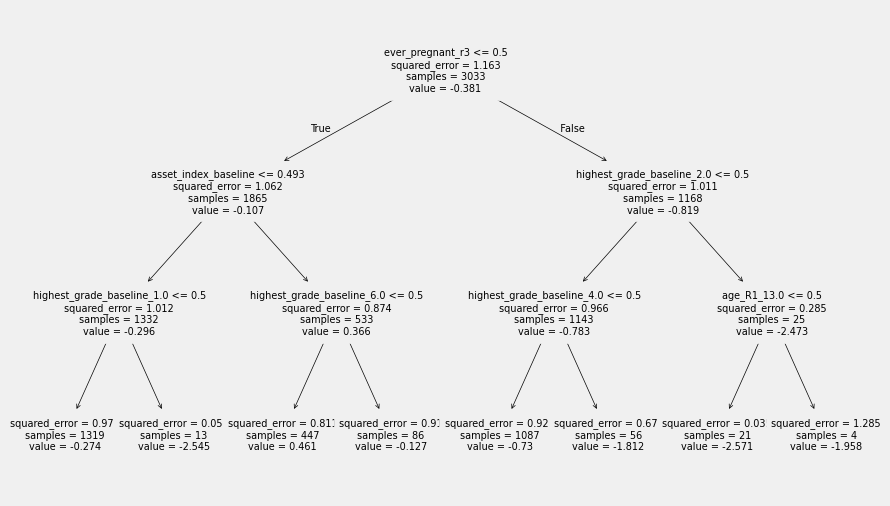

In [20]:
treedata = pd.get_dummies(alldata, columns = ['hhsize', 'highest_grade_baseline', 'age_R1'], 
                         drop_first=False)

treedata['treatment_year3*uncond_treat_year3'] = treedata['treatment_year3'] * treedata['uncond_treat_year3']
treedata['treatment_year3*cond_treat_year3'] = treedata['treatment_year3'] * treedata['cond_treat_year3']
treedata['treatment*cond*asset_index_baseline'] = treedata['asset_index_baseline'] * treedata['treatment_year3']*treedata['cond_treat_year3']
treedata['treatment*uncond*asset_index_baseline'] = treedata['asset_index_baseline'] * treedata['treatment_year3']*treedata['uncond_treat_year3']

X = treedata.drop(columns=['math_malawi_std', 'eng_std', 'cog_std', 'inschool_term1_2010', 'num_terms_enrolled', 'treatment_year3', 'uncond_treat_year3', 'cond_treat_year3'])
X = sm.add_constant(X)   
y = treedata['math_malawi_std']

High = np.where(treedata['math_malawi_std'] > treedata['math_malawi_std'].mean(),
                "Yes",
                "No")

model = MS(X.columns, intercept=False)
D = model.fit_transform(X)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                treedata['math_malawi_std'],
                                test_size=0.3,
                                random_state=0)
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X, High)

reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(10,6))[1]
plot_tree(reg,
          feature_names=feature_names,
          fontsize=7, 
          ax=ax);

ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
best_ = grid.best_estimator_
treemse = np.mean((y_test - best_.predict(X_test))**2)

print("Accuracy Score:", accuracy_score(High, clf.predict(X)))
print("MSE:", treemse)

## Bagging

CV MSE:  0.6048076796152659
MSE: 0.6312024789082266


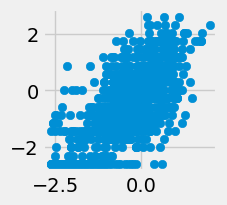

In [21]:
bag_data = RF(max_features=X_train.shape[1], random_state=0)
bag_data.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
mse_scores = cross_val_score(
    bag_data, X_train, y_train,
    cv=cv, scoring="neg_mean_squared_error", n_jobs=-1
)
mse_scores = (-mse_scores)

print("CV MSE: " , (mse_scores.mean()))
bag_cv_mse = mse_scores.mean()

bag_data.fit(X_train, y_train)

ax = subplots(figsize=(2,2))[1]
y_hat_bag = bag_data.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bagmse = np.mean((y_test - y_hat_bag)**2) #MSE
print("MSE:", bagmse)

## 6. Random Forest:

In [22]:
param_grid = {
    "n_estimators": [50, 100, 250],
    "max_features": [4, 6, 8, 10],
    "max_depth": [None, 10, 20],
}
gs = GridSearchCV(
    RF(max_features=X_train.shape[1], bootstrap=True, random_state=0),
    param_grid, cv=5, scoring="neg_mean_squared_error"
)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV MSE:", (gs.best_score_))

rf_best = gs.best_estimator_
y_pred = rf_best.predict(X_test)
print("Test RMSE:", (mean_squared_error(y_test, y_pred)))

rf_cv_mse = gs.best_score_
rf_test_mse = (mean_squared_error(y_test, y_pred))

feature_imp = pd.DataFrame(
    {'importance': rf_best.feature_importances_},
    index=feature_names)

Best params: {'max_depth': 20, 'max_features': 10, 'n_estimators': 250}
Best CV MSE: -0.6119366894156026
Test RMSE: 0.6007582392178459


## 7. Boosting

In [23]:
gbr = GBR(
    random_state=0,
    n_iter_no_change=20, 
    validation_fraction=0.1 
)

param_grid = {
    "learning_rate":  [0.001, 0.05],
    "n_estimators":   [100, 250, 500],
    "max_depth":      [2, 3, 4],
    "subsample":      [1.0, 0.7],
    "max_features":   [None, "sqrt"]
}

cv = KFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=cv,
    refit=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV MSE:", (gs.best_score_))

gbr_best = gs.best_estimator_
y_pred = gbr_best.predict(X_test)
print("Test RMSE:", (mean_squared_error(y_test, y_pred)))

boost_cv_mse = gs.best_score_
boost_test_mse = (mean_squared_error(y_test, y_pred))

pd.DataFrame([treemse, bag_cv_mse, rf_test_mse, boost_test_mse],
             ['Regression Tree', 'Bagging', 'Random Forest', 'Boosting']
             ).rename(columns={0:'MSE'})

Best params: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': None, 'n_estimators': 250, 'subsample': 0.7}
Best CV MSE: 0.4315350603226976
Test RMSE: 0.6933785595190922


,MSE
Regression Tree,0.991538
Bagging,0.604808
Random Forest,0.600758
Boosting,0.693379


## Defining DAG:

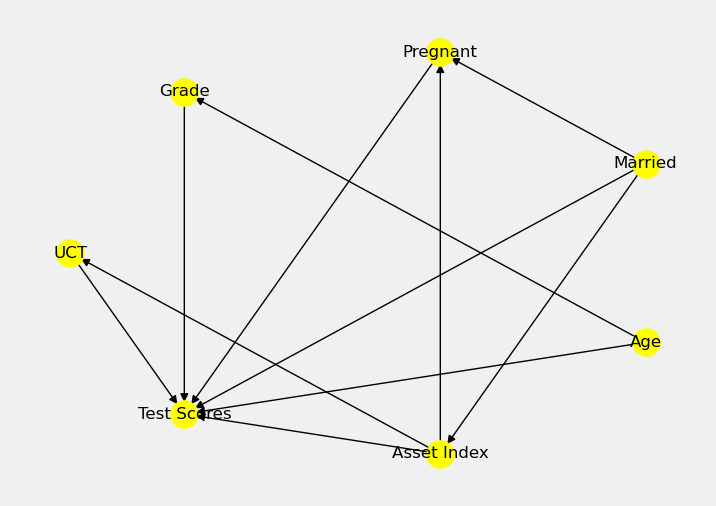

In [20]:
# Define the graph
sample_gml = """graph [
directed 1

node [
    id 0
    label "UCT"
    ]

node [
    id 2
    label "Test Scores"
    ]
node [
    id 3
    label "Asset Index"
    ]
node [
    id 4
    label "Age"
    ]  
node [
    id 5
    label "Married"
    ]  
node [
    id 6
    label "Pregnant"
    ]  
node [
    id 7
    label "Grade"
    ]    

edge [
    source 0
    target 2
    ]

edge [
    source 3
    target 0
    ]
edge [
    source 3
    target 2
    ]
edge [
    source 4
    target 2
    ]
edge [
    source 5
    target 2
    ]
edge [
    source 6
    target 2
    ]
edge [
    source 7
    target 2
    ]
edge [
    source 5
    target 3
    ]
edge [
    source 3
    target 6
    ]
edge [
    source 4
    target 7
    ]
edge [
    source 5
    target 6
    ]
]
    
    """

graph = nx.parse_gml(sample_gml)
model = CausalModel(
    data=alldata,
    treatment=['CCT'],
    outcome='Test Scores',
    graph=sample_gml)
model.view_model()

In [42]:
nx.algorithms.d_separated = nx.algorithms.d_separation.is_d_separator
nx.d_separated = nx.algorithms.d_separation.is_d_separator

In [43]:
estimand = model.identify_effect()
print(estimand)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')
print(estimate)

INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
ERROR:dowhy.causal_model:No valid identified estimand available.


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
Estimation failed! No relevant identified estimand available for this estimation method.


# 8. Matching

In [21]:
from sklearn.neighbors import KNeighborsRegressor

X = ['ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1',
       'never_had_sex_baseline', 'treated',
        'ever_married_r3']
#'ever_pregnant_r3','treatment_year3*uncond_treat_year3','treatment_year3*cond_treat_year3','treatment_year3*cond_treat_year3*asset_index_baseline','treatment_year3*uncond_treat_year3*asset_index_baseline'
y = "eng_std"

# alldata = alldata.assign(**{f: (alldata[f] - alldata[f].mean())/alldata[f].std() for f in X})

treated = alldata.query("treated==1.0")
untreated = alldata.query("treated==0.0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

,asset_index_baseline,ever_pregnant,never_had_sex,hhsize,female_headed,highest_grade_baseline,father_alive,mother_alive,age_R1,never_had_sex_baseline,math_malawi_std,eng_std,cog_std,num_terms_enrolled,ever_pregnant_r3,ever_married_r3,heterogeneous_asset_treatment,treated,match
31,0.795718,0.0,1,7.0,1.0,4.0,0,1,16.0,1.0,-2.612129,-2.270203,-1.566874,0.0,0.0,0,0.795718,1.0,-2.042327
32,0.679417,0.0,1,8.0,0.0,4.0,1,1,16.0,1.0,-1.157970,-1.358698,-0.727200,0.0,1.0,1,0.679417,1.0,-1.814450
33,0.340942,0.0,1,8.0,0.0,8.0,1,1,17.0,1.0,-0.285475,0.236436,1.791821,5.0,1.0,0,0.000000,1.0,-1.130822
34,0.340942,0.0,1,8.0,0.0,7.0,1,1,13.0,1.0,0.587020,0.692188,-0.307363,6.0,0.0,0,0.000000,1.0,-0.902946
35,0.063753,1.0,0,3.0,1.0,7.0,0,0,16.0,0.0,-0.867139,-1.358698,-0.307363,6.0,1.0,1,0.063753,1.0,-1.358698


In [22]:
np.mean((2*predicted["treated"] - 1)*(predicted["math_malawi_std"] - predicted["match"]))

In [23]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted.tail()

,asset_index_baseline,ever_pregnant,never_had_sex,hhsize,female_headed,highest_grade_baseline,father_alive,mother_alive,age_R1,never_had_sex_baseline,math_malawi_std,eng_std,cog_std,num_terms_enrolled,ever_pregnant_r3,ever_married_r3,heterogeneous_asset_treatment,treated,match,bias_correct
5284,0.181811,0.0,1,7.0,0.0,6.0,1,1,14.0,1.0,-0.576307,0.464312,-0.307363,6.0,0.0,0,0.0,0.0,-1.130822,0.0
5285,0.054684,0.0,1,9.0,0.0,6.0,1,1,17.0,1.0,-0.867139,0.236436,0.112474,6.0,0.0,0,0.0,0.0,-0.902946,0.0
5287,0.054684,0.0,1,9.0,0.0,6.0,1,1,17.0,1.0,-0.867139,0.236436,0.112474,6.0,0.0,0,0.0,0.0,-0.902946,0.0
5288,0.054684,0.0,1,9.0,0.0,6.0,1,1,17.0,1.0,-0.867139,0.236436,0.112474,6.0,0.0,0,0.0,0.0,-0.902946,0.0
5289,0.406670,0.0,1,6.0,1.0,6.0,0,1,14.0,1.0,-0.576307,-0.447193,0.952148,6.0,0.0,0,0.0,0.0,0.236436,0.0


With bias correction:

In [24]:
np.mean((2*predicted["treated"] - 1)*((predicted["math_malawi_std"] - predicted["match"])-predicted["bias_correct"]))

### Propensity Score

In [25]:
data_with_categ = alldata[['ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1','never_had_sex_baseline', 'treated','math_malawi_std', 'heterogeneous_asset_treatment']]
#removing EA status fixed everything

In [26]:
data_with_categ = alldata[['ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1','never_had_sex_baseline','math_malawi_std', 'treated']]
#removing EA status fixed everything

In [27]:
T = 'treated'
Y = 'math_malawi_std'
X = data_with_categ.columns.drop([T, Y])
X = X.dropna()
# X_scaled = scaler.fit_transform(X)

ps_model = LogisticRegression().fit(data_with_categ[X], data_with_categ[T])

data_ps = data_with_categ.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps.head()

,ever_pregnant,never_had_sex,hhsize,female_headed,highest_grade_baseline,father_alive,mother_alive,age_R1,never_had_sex_baseline,math_malawi_std,treated,propensity_score
1,0.0,1,9.0,0.0,9.0,1,1,22.0,1.0,-1.739634,0.0,0.379629
2,0.0,1,7.0,0.0,5.0,1,1,15.0,1.0,-2.030465,0.0,0.509239
3,0.0,1,7.0,0.0,6.0,1,1,14.0,1.0,0.877852,0.0,0.498610
4,1.0,0,2.0,1.0,8.0,1,1,22.0,0.0,-0.285475,0.0,0.505027
5,0.0,0,8.0,0.0,4.0,1,1,18.0,0.0,-2.612129,0.0,0.512806


In [28]:
weight_t = 1/data_ps.query("treated==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("treated==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 11388
Treated Population Sample Size 4122.4023567982595
Untreated Population Sample Size 4127.591424052182


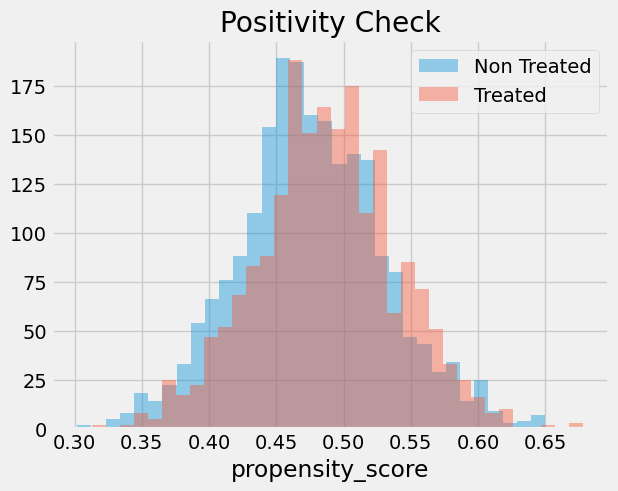

In [29]:
import seaborn as sns
sns.distplot(data_ps.query("treated==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("treated==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [168]:
weight = ((data_ps["treated"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("treated==1")["math_malawi_std"]*weight_t) / len(data)
y0 = sum(data_ps.query("treated==0")["math_malawi_std"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["math_malawi_std"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: -0.218347106743672
Y0: -0.3944287806903004
ATE 0.17608167394662835


#### Bootstrapping

In [68]:
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.010572751881244185
95% C.I.: (np.float64(-0.04097255543432387), np.float64(0.06476072953729067))


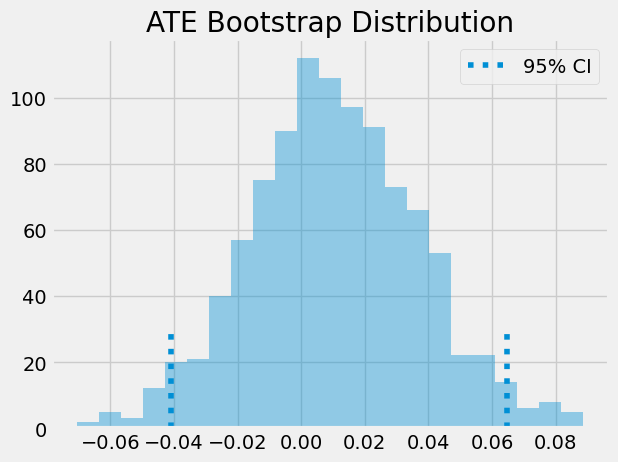

In [69]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

# 9. Meta Learners

In [30]:
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [32]:
T = 'treated'
y = 'math_malawi_std'
X = data_with_categ.columns.drop([T, y])

## 9.1 S-Learner

In [36]:
X = alldata[[ 'ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1','never_had_sex_baseline', 'treated',
             'eng_std']]
# X = sm.add_constant(X)   
y = alldata['eng_std']
T = alldata['treated']

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                alldata['eng_std'],
                                test_size=0.3,
                                random_state=0)

X = ['ever_pregnant', 'never_had_sex', 'hhsize',
       'female_headed', 'highest_grade_baseline', 'father_alive',
       'mother_alive', 'age_R1','never_had_sex_baseline', 
     'eng_std']
y = 'eng_std'
T = 'treated'

In [37]:
np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(X_train[X+[T]], X_train[y]);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 2887, number of used features: 11
[LightGBM] [Info] Start training from score -0.385705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [265]:
s_learner_cate_train = (s_learner.predict(X_train[X].assign(**{T: 1})) -
                        s_learner.predict(X_train[X].assign(**{T: 0})))

s_learner_cate_test = X_test.assign(
    cate=(s_learner.predict(X_test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(X_test[X].assign(**{T: 0}))) # predict under control
)

In [266]:
s_learner_cate_train.mean()

## 9.2 T-Learner

In [270]:
X_train = X_train.rename(columns={'treated':'treatment'})
X_test = X_test.rename(columns={'treated':'treatment'})
T = 'treatment'

In [271]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(X_train.query(f"{T}==0")[X], X_train.query(f"{T}==0")[y])
m1.fit(X_train.query(f"{T}==1")[X], X_train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(X_train[X]) - m0.predict(X_train[X])
t_learner_cate_test = X_test.assign(cate=m1.predict(X_test[X]) - m0.predict(X_test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 10
[LightGBM] [Info] Start training from score -0.477691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [272]:
t_learner_cate_train.mean()

## 9.3 X-Learner

In [275]:
np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None) 

m0.fit(X_train.query(f"{T}==0")[X], X_train.query(f"{T}==0")[y])
m1.fit(X_train.query(f"{T}==1")[X], X_train.query(f"{T}==1")[y])
                       
g.fit(X_train[X], X_train[T]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 10
[LightGBM] [Info] Start training from score -0.477691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

ValueError: Input y contains NaN.

In [276]:
d_train = np.where(X_train[T]==0,
                   m1.predict(X_train[X]) - X_train[y],
                   X_train[y] - m0.predict(X_train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(X_train.query(f"{T}==0")[X], d_train[X_train[T]==0])
mx1.fit(X_train.query(f"{T}==1")[X], d_train[X_train[T]==1]);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 10
[LightGBM] [Info] Start training from score -0.013394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [39]:
# def ps_predict(df, t): 
#     return g.predict_proba(df[X])[:, t]
    
    
# x_cate_train = (ps_predict(X_train,1)*mx0.predict(X_train[X]) +
#                 ps_predict(X_train,0)*mx1.predict(X_train[X]))

# x_cate_test = X_test.assign(cate=(ps_predict(X_test,1)*mx0.predict(X_test[X]) +
#                                 ps_predict(X_test,0)*mx1.predict(X_test[X])))

In [244]:
x_cate_train.mean()

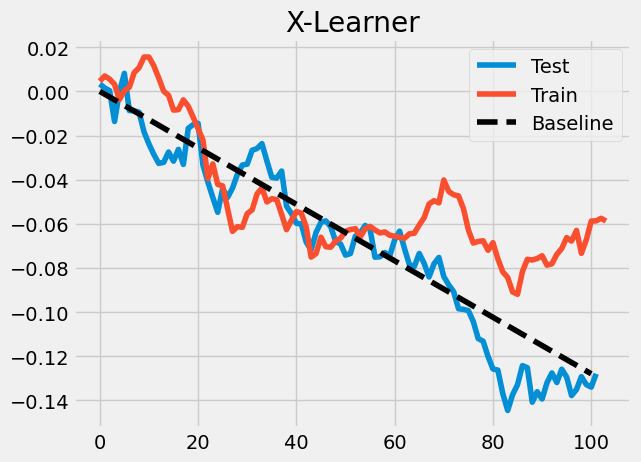

In [85]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="math_malawi_std", t="treatment")
gain_curve_train = cumulative_gain(X_train.assign(cate=x_cate_train), "cate", y="math_malawi_std", t="treatment")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(X_test, "math_malawi_std", "treatment")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

# 9.4 Meta Learners (with a different package)

In [358]:
data = alldata
data = data.dropna()

y = 'math_malawi_std'
t = 'treated'
X = ['asset_index_baseline','ever_pregnant', 'never_had_sex', 'hhsize',
    'female_headed', 'highest_grade_baseline', 'father_alive','ever_married_r3']

X_mat = data[X].values
t_vec = data[t].values
y_vec = data[y].values

In [359]:
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

ate_s = learner_s.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.0184947]), array([-0.03405859]), array([0.071048]))
ATE estimate: 0.018
ATE lower bound: -0.034
ATE upper bound: 0.071
(array([0.0184947]), array([-0.03405859]), array([0.071048]))
ATE estimate: 0.018
ATE lower bound: -0.034
ATE upper bound: 0.071


In [360]:
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.05678398]), array([0.02263749]), array([0.09093047]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.05678398]), array([0.02263749]), array([0.09093047]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.01826825]), array([-0.033998]), array([0.07053451]))


In [361]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X_mat, treatment=t_vec, y=y_vec)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.07396019]), array([0.0441207]), array([0.10379967]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.01826833]), array([-0.03399793]), array([0.07053458]))


# 10. Doubly Robust

#### CIBT

In [86]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [87]:
data = alldata
y = 'math_malawi_std'
t = 'treated'
X = ['asset_index_baseline', 'ever_pregnant', 'never_had_sex', 'hhsize',
    'female_headed', 'highest_grade_baseline', 'father_alive','ever_married_r3']

X_mat = data[X].values
t_vec = data[t].values
y_vec = data[y].values

In [88]:
doubly_robust(data, X, t, y)

In [89]:
np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data.sample(frac=1, replace=True), X, t, y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (np.float64(-0.032834846552927024), np.float64(0.0738307919910411))


# 11. DML 

Linear Model

In [52]:
Y = alldata['math_malawi_std'].values
T = (alldata["treated"]).values
X=(alldata[[ 'ever_pregnant', 'never_had_sex', 'hhsize',
    'female_headed', 'highest_grade_baseline', 'father_alive','ever_married_r3']].values)

In [72]:
dml = LinearDML(
    model_y=RF(n_estimators=50),
    model_t = LogisticRegression(),
    discrete_treatment=True,
    cv=3,
    random_state=42
)

dml.fit(Y, T, X=X)

cate_hat_1 = dml.effect(X)
ate_hat = np.mean(cate_hat_1)

print(ate_hat)

0.08424828867596129


In [73]:
dml = CausalForestDML(
    model_y=RF(n_estimators=50),
    model_t = LogisticRegression(),
    discrete_treatment=True,
    cv=3,
    random_state=42
)

dml.fit(Y, T, X=X)

cate_hat_2 = dml.effect(X)
ate_hat = np.mean(cate_hat_2)

print(ate_hat)

0.07287491362388347


Text(0.5, 1.0, 'Cumulative Gain')

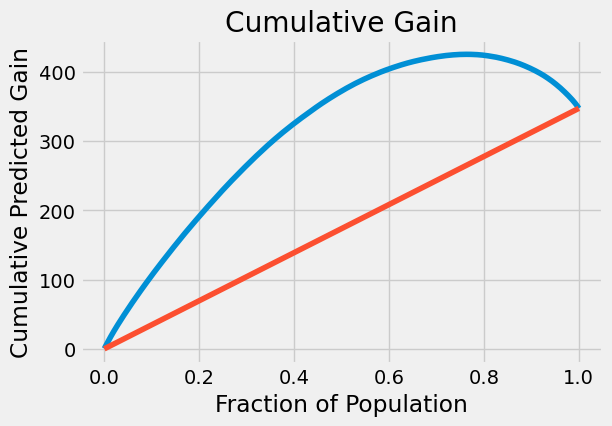

In [74]:
df_gain = alldata.copy()
df_gain['cate_hat'] = cate_hat_1
df_gain = df_gain.sort_values('cate_hat', ascending=False).reset_index(drop=True)

n = len(df_gain)

df_gain['fraction'] = (np.arange(n)+1)/n
df_gain['cum_uplift'] = df_gain['cate_hat'].cumsum()
total_uplift = df_gain['cum_uplift'].iloc[-1]

plt.figure(figsize=(6,4))
plt.plot(df_gain['fraction'], df_gain['cum_uplift'], label='DML')

plt.plot([0,1], [0, total_uplift], label='Random (No Model)')

plt.xlabel('Fraction of Population')
plt.ylabel('Cumulative Predicted Gain')
plt.title('Cumulative Gain')

Text(0.5, 1.0, 'Cumulative Gain')

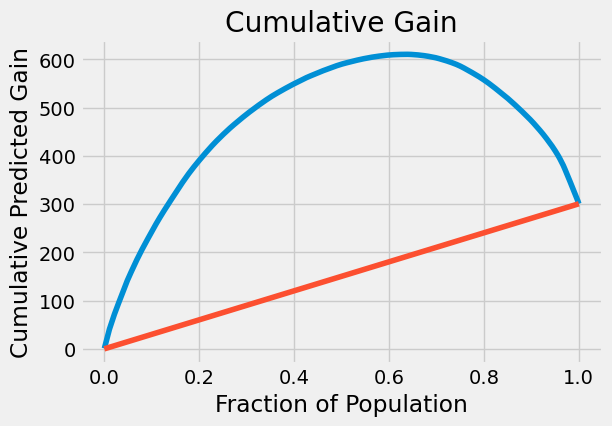

In [75]:
df_gain = alldata.copy()
df_gain['cate_hat'] = cate_hat_2
df_gain = df_gain.sort_values('cate_hat', ascending=False).reset_index(drop=True)

n = len(df_gain)

df_gain['fraction'] = (np.arange(n)+1)/n
df_gain['cum_uplift'] = df_gain['cate_hat'].cumsum()
total_uplift = df_gain['cum_uplift'].iloc[-1]

plt.figure(figsize=(6,4))
plt.plot(df_gain['fraction'], df_gain['cum_uplift'], label='DML')

plt.plot([0,1], [0, total_uplift], label='Random (No Model)')

plt.xlabel('Fraction of Population')
plt.ylabel('Cumulative Predicted Gain')
plt.title('Cumulative Gain')